# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [68]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
import pdb
import matplotlib.pyplot as plt

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [ ]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [4]:
path = untar_data(URLs.IMAGENETTE); path

PosixPath('/home/jupyter/.fastai/data/imagenette')

In [6]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagewoof/val'),
 PosixPath('/home/jupyter/.fastai/data/imagewoof/train')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [5]:
tfms = get_transforms()

In [282]:
data = (ImageDataBunch.from_folder(path,ds_tfms=tfms, size=128,valid = "val")).normalize()

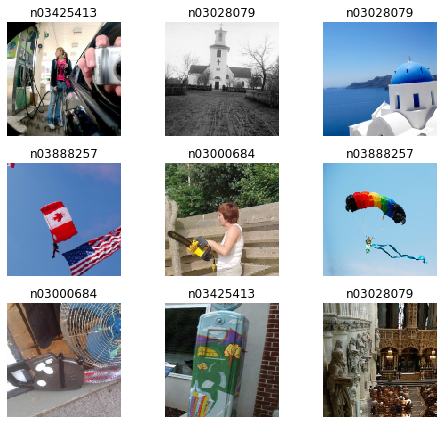

In [283]:
data.show_batch(rows=3, figsize=(7,6))

In [284]:
print(data.classes)
len(data.classes),data.c

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


(10, 10)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [285]:
class FilterStats(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.weight_collection = None
        self.previous_shape=[]
        
        
    def on_epoch_begin(self, **kwargs):
        self.batch_number=1
        super().on_epoch_begin(**kwargs)
        
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        #pdb.set_trace()
        
        self.layer+=1
        if len(m.weight.shape)==4 and self.batch_number==1:
            if m.weight.shape!=self.previous_shape:
                self.weight_rep=torch.empty(m.weight.shape)
                self.weight_rep=torch.nn.init.kaiming_normal_(self.weight_rep)
                self.previous_shape=m.weight.shape
            print(self.layer)
            reset_sheets=0
            for output_neuron in range(m.weight.shape[0]):
                for input_neuron in range(m.weight.shape[1]):
                    if random.random()<0.1:
                        with torch.no_grad():
                            #pdb.set_trace()
                            m.weight[output_neuron,input_neuron].data=self.weight_rep[output_neuron,input_neuron]
                            reset_sheets+=1
            print("reset sheets:",reset_sheets)
            
        return m.weight,self.layer
    
    def on_batch_begin(self,**kwargs):
        self.layer=-1
        super().on_batch_begin(**kwargs)
        
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        #pdb.set_trace()
        self.batch_number +=1
        if False:
            for values, layer in self.hooks.stored:
                 if layer == 40 and train:
                    if not self.weight_collection is None:
                        self.weight_collection=torch.cat((self.weight_collection,torch.unsqueeze(values,dim=0)),dim = 0)
                    else:
                        self.weight_collection=torch.unsqueeze(values,dim=0)

    def on_train_end(self, **kwargs):
        "Polish the final result."
        #self.stats = tensor(self.stats).permute(2,1,0)

In [286]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,pretrained=False,callback_fns=[FilterStats])

In [132]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [107]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


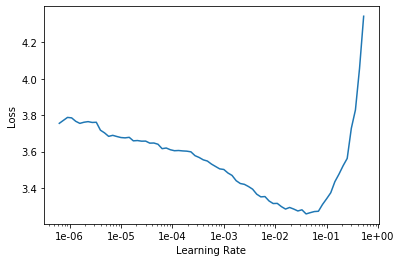

In [108]:
learn.recorder.plot()

In [287]:
lr=1e-2

# Sheet reset

In [ ]:
learn.fit_one_cycle(5,lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.363656,3.673329,0.640000,00:59
1,2.619901,2.153733,0.778000,00:59
2,2.204500,2.005584,0.696000,00:59
3,1.778184,1.492060,0.534000,00:59


0
reset sheets: 16
2
reset sheets: 395
4
reset sheets: 416
6
reset sheets: 394
8
reset sheets: 399
10
reset sheets: 400
12
reset sheets: 391
14
reset sheets: 819
16
reset sheets: 1724
18
reset sheets: 826
20
reset sheets: 1612
22
reset sheets: 1600
24
reset sheets: 1661
26
reset sheets: 1625
28
reset sheets: 1660
30
reset sheets: 1695
32
reset sheets: 3228
34
reset sheets: 6417
36
reset sheets: 3185
38
reset sheets: 6478
40
reset sheets: 6521
42
reset sheets: 6506
44
reset sheets: 6543
46
reset sheets: 6690
48
reset sheets: 6558
50
reset sheets: 6480
52
reset sheets: 6661
54
reset sheets: 6645
56
reset sheets: 6492
58
reset sheets: 13256
60
reset sheets: 26347
62
reset sheets: 13084
64
reset sheets: 26115
66
reset sheets: 26212
68
reset sheets: 26370
70
reset sheets: 26424
0
reset sheets: 21
2
reset sheets: 392
4
reset sheets: 390
6
reset sheets: 417
8
reset sheets: 397
10
reset sheets: 392
12
reset sheets: 387
14
reset sheets: 794
16
reset sheets: 1656
18
reset sheets: 805
20
reset sh

In [269]:
learn.fit_one_cycle(7,lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.337860,1.177150,0.372000,01:09
1,1.431931,29.309273,0.652000,01:08
2,1.296923,0.993475,0.322000,01:09
3,1.037637,0.824480,0.248000,01:09
4,0.902273,0.668130,0.206000,01:09
5,0.758680,0.525040,0.160000,01:12


0
reset sheets: 22
2
reset sheets: 394
4
reset sheets: 379
6
reset sheets: 409
8
reset sheets: 436
10
reset sheets: 387
12
reset sheets: 393
14
reset sheets: 822
16
reset sheets: 1588
18
reset sheets: 817
20
reset sheets: 1655
22
reset sheets: 1642
24
reset sheets: 1639
26
reset sheets: 1618
28
reset sheets: 1682
30
reset sheets: 1574
32
reset sheets: 3288
34
reset sheets: 6560
36
reset sheets: 3287
38
reset sheets: 6377
40
reset sheets: 6527
42
reset sheets: 6569
44
reset sheets: 6711
46
reset sheets: 6519
48
reset sheets: 6693
50
reset sheets: 6398
52
reset sheets: 6506
54
reset sheets: 6492
56
reset sheets: 6501
58
reset sheets: 12885
60
reset sheets: 25936
62
reset sheets: 12995
64
reset sheets: 26197
66
reset sheets: 25941
68
reset sheets: 26211
70
reset sheets: 26443
0
reset sheets: 16
2
reset sheets: 378
4
reset sheets: 386
6
reset sheets: 437
8
reset sheets: 378
10
reset sheets: 401
12
reset sheets: 403
14
reset sheets: 789
16
reset sheets: 1652
18
reset sheets: 847
20
reset sh

RuntimeError: CUDA out of memory. Tried to allocate 2.89 GiB (GPU 0; 14.73 GiB total capacity; 8.50 GiB already allocated; 2.89 GiB free; 2.56 GiB cached)

# No sheet reset

In [277]:
learn.fit_one_cycle(5,lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.372450,1.905979,0.608000,01:04
1,1.773698,1.381187,0.460000,01:06
2,1.398704,1.108232,0.364000,01:06
3,1.146663,0.741520,0.224000,01:06
4,0.927949,0.624736,0.184000,01:05


In [245]:
learn.fit_one_cycle(7,lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.309209,1.843650,0.442000,01:06
1,1.536975,1.422016,0.434000,01:06
2,1.583639,2.341058,0.402000,01:06


KeyboardInterrupt: 

In [111]:
learn.filter_stats.weight_collection.shape

torch.Size([201, 256, 256, 3, 3])

In [215]:
weights=learn.filter_stats.weight_collection

In [216]:
weight_one_neuron=weights[:,7]
weight_one_neuron.shape

torch.Size([201, 256, 3, 3])

In [223]:
mean_per_input=weight_one_neuron.mean((2,3))[:,:10]
std_per_input=weight_one_neuron.std((2,3))[:,:10]
norm_per_input=weight_one_neuron.norm(dim=(2,3))[:,:30]
single_value=weight_one_neuron[:,3,1,1]

In [224]:
norm_per_input

tensor([[0.0768, 0.0951, 0.0513,  ..., 0.0814, 0.0732, 0.0941],
        [0.0768, 0.0951, 0.0513,  ..., 0.0814, 0.0732, 0.0941],
        [0.0769, 0.0951, 0.0513,  ..., 0.0814, 0.0732, 0.0941],
        ...,
        [0.0807, 0.0911, 0.0482,  ..., 0.0787, 0.0742, 0.0930],
        [0.0807, 0.0911, 0.0482,  ..., 0.0787, 0.0742, 0.0930],
        [0.0807, 0.0911, 0.0482,  ..., 0.0787, 0.0742, 0.0930]],
       device='cuda:0', grad_fn=<SliceBackward>)

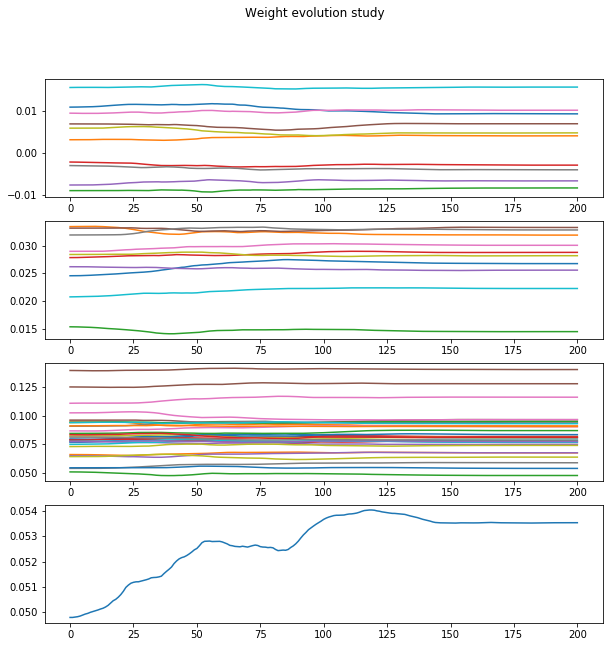

In [225]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4,figsize=(10,10))
fig.suptitle('Weight evolution study')
ax1.plot(range(len(mean_per_input)), mean_per_input)
ax2.plot(range(len(std_per_input)), std_per_input)
ax3.plot(range(len(norm_per_input)), norm_per_input)
ax4.plot(range(len(single_value)), single_value)

In [118]:
0.05*64

3.2

In [213]:
learn.filter_stats.stats

AttributeError: 'Learner' object has no attribute 'stats'

In [214]:
filtered_stats = []
for batch in learn.filter_stats.stats:
    for stat in batch:
        if not stat is None:
            values,layer = stat
            #pdb.set_trace()
            if layer==4:
                filtered_stats.append(values)

AttributeError: 'Learner' object has no attribute 'stats'

In [26]:
len(filtered_stats)

402

In [23]:
values

Parameter containing:
tensor([[[[ 3.2805e-02, -4.9870e-03,  1.4406e-02],
          [ 1.6749e-02, -4.1793e-03,  7.0611e-03],
          [ 4.8323e-02,  5.4307e-02,  6.0470e-02]],

         [[ 9.2926e-03, -4.2709e-02, -5.0245e-02],
          [ 9.7874e-03, -2.9493e-03,  9.0642e-02],
          [ 1.7964e-01, -6.5247e-03, -8.7518e-02]],

         [[-1.4949e-02,  3.1516e-02, -2.3853e-02],
          [ 7.4328e-02, -4.7639e-02,  2.7805e-02],
          [ 9.3556e-02,  8.4646e-03,  2.0954e-02]],

         ...,

         [[-7.0250e-02,  2.2549e-02, -1.3306e-01],
          [ 1.2238e-02,  1.2536e-01,  4.8459e-02],
          [-7.3092e-02, -1.4448e-02,  7.2784e-02]],

         [[-6.6043e-02, -7.9395e-02,  1.0473e-01],
          [-1.2611e-02, -1.0417e-02,  3.5188e-02],
          [-3.0840e-02,  6.7071e-03, -3.1268e-03]],

         [[ 2.9216e-02,  1.1724e-02,  8.9371e-03],
          [-7.7196e-02,  2.8145e-02,  7.8512e-02],
          [-1.8274e-02, -5.0361e-02,  2.2550e-03]]],


        [[[-2.9076e-02, -2.8379

In [ ]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

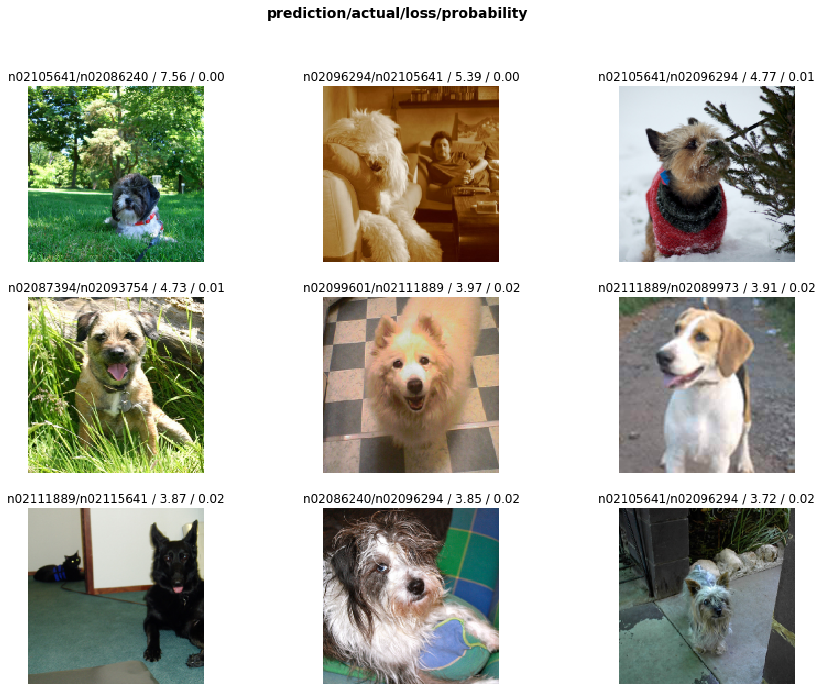

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

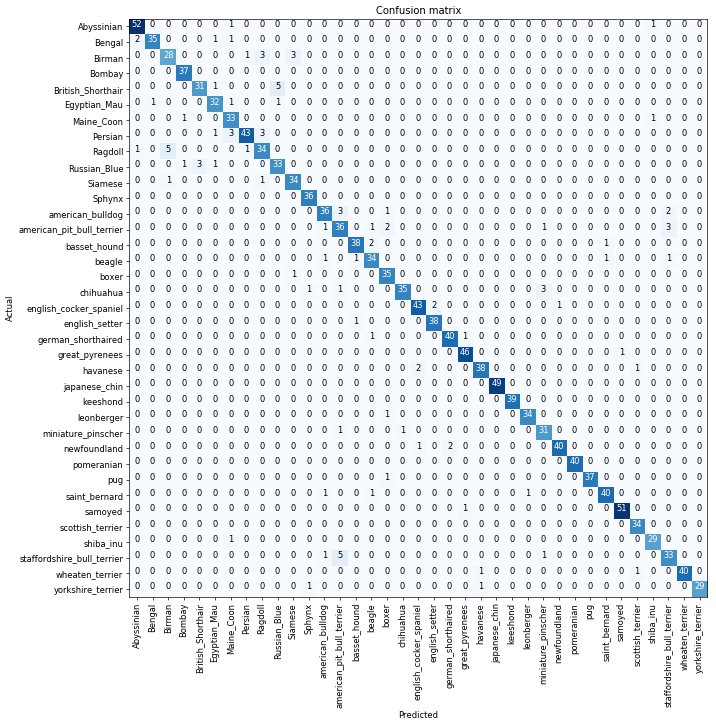

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('British_Shorthair', 'Russian_Blue', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Birman', 'Ragdoll', 3),
 ('Birman', 'Siamese', 3),
 ('Persian', 'Maine_Coon', 3),
 ('Persian', 'Ragdoll', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('chihuahua', 'miniature_pinscher', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.558166,0.314579,0.101489


In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


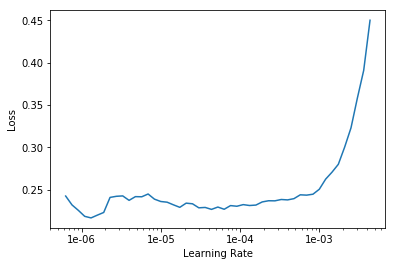

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.242544,0.208489,0.067659
2,0.206940,0.204482,0.062246


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


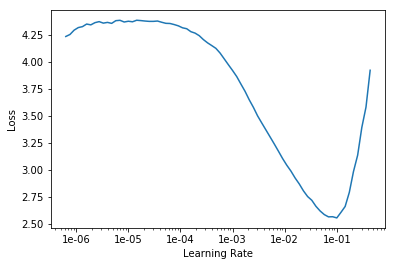

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

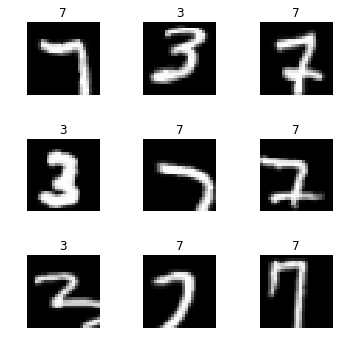

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

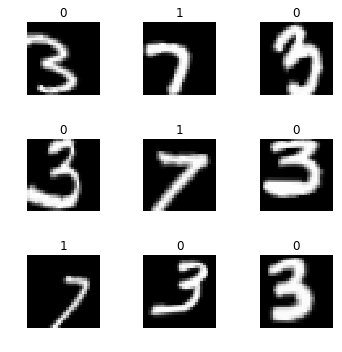

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']